#### By: Peyman Shahidi
#### Created: Dec 16, 2025
#### Last Edit: Dec 18, 2025

<br>

In [19]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [20]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data/computed_objects/tasks_sequences_robustness"
output_data_path = f'{input_data_path}/data/computed_objects/GPT_task_sequences_overlap_analysis'
output_plot_path = f"{main_folder_path}/writeup/plots/GPT_task_sequences_overlap_analysis"

In [21]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

### Main Code

In [22]:
from pathlib import Path
import pandas as pd
import re

base_dir = Path(input_data_path)

dfs = []

for folder in base_dir.iterdir():
    if not folder.is_dir():
        continue

    occupation = folder.name

    for csv_file in folder.glob("*.csv"):
        # Expect: <occupation>_X.csv
        match = re.search(rf"{re.escape(occupation)}_(\d+)\.csv$", csv_file.name)
        if match is None:
            continue  # skip files that don't match the convention

        prompt_number = int(match.group(1))

        df = pd.read_csv(csv_file)
        df["prompt_number"] = prompt_number

        dfs.append(df)

# Combine everything
master_df = pd.concat(dfs, ignore_index=True)

# Save if you want
# master_df.to_csv("masterfile.csv", index=False)


In [23]:
from scipy.stats import kendalltau
import itertools
import pandas as pd


def find_bad_prompts(df_occ):
    bad = (
        df_occ
        .groupby(["prompt_number", "Task ID"])
        .size()
        .reset_index(name="n")
        .query("n > 1")
        ["prompt_number"]
        .unique()
    )
    return set(bad)


def compute_pairwise_kendall_drop_bad(df_occ):

    bad_prompts = find_bad_prompts(df_occ)

    df_clean = df_occ[~df_occ["prompt_number"].isin(bad_prompts)]

    # need at least 2 prompts
    if df_clean["prompt_number"].nunique() < 2:
        return pd.DataFrame()

    rankings = {}

    for p, g in df_clean.groupby("prompt_number"):
        rankings[p] = (
            g.sort_values("Task Position")
             .set_index("Task ID")["Task Position"]
        )

    results = []

    for p1, p2 in itertools.combinations(rankings.keys(), 2):
        r1 = rankings[p1]
        r2 = rankings[p2]

        common_tasks = r1.index.intersection(r2.index)

        if len(common_tasks) < 2:
            continue

        tau, _ = kendalltau(
            r1.loc[common_tasks].values,
            r2.loc[common_tasks].values
        )

        results.append({
            "prompt_1": p1,
            "prompt_2": p2,
            "kendall_tau": tau
        })

    return pd.DataFrame(results)


all_results = []

for occ, df_occ in master_df.groupby("Detailed_Occupation_Title"):
    res = compute_pairwise_kendall_drop_bad(df_occ)
    if not res.empty:
        res["occupation"] = occ
        all_results.append(res)

kendall_results = pd.concat(all_results, ignore_index=True)
kendall_results

,prompt_1,prompt_2,kendall_tau,occupation
0,0,1,-0.14,Administrative Services Managers
1,0,2,0.57,Administrative Services Managers
2,0,3,0.36,Administrative Services Managers
3,0,4,0.36,Administrative Services Managers
4,0,5,0.50,Administrative Services Managers
...,...,...,...,...
3926,7,9,0.36,Zoologists and Wildlife Biologists
3927,7,10,0.34,Zoologists and Wildlife Biologists
3928,8,9,0.80,Zoologists and Wildlife Biologists
3929,8,10,0.65,Zoologists and Wildlife Biologists


In [24]:
# Read merged data for occupation codes and titles to map to occupational analysis dataset later
merged_data = pd.read_csv(f"{main_folder_path}/data/computed_objects/ONET_Eloundou_Anthropic_GPT/ONET_Eloundou_Anthropic_GPT.csv")
merged_data = merged_data[["Detailed_Occupation_Title", "Detailed_Occupation_Code", "O*NET-SOC Code"]].drop_duplicates()

# Read occupation-level stats and merge back detailed_occupation_title and codes
occupation_analysis = pd.read_csv(f"{main_folder_path}/data/computed_objects/fragmentationIndex/occupation_analysis_with_fragmentationIndex_def4.csv")
occupation_analysis = occupation_analysis.merge(merged_data, on="O*NET-SOC Code", how="left")

# Aggregate by Detailed_Occupation_Title, Detailed_Occupation_Code, O*NET-SOC Code
occupation_analysis = occupation_analysis.groupby(["Detailed_Occupation_Title", "Detailed_Occupation_Code", "O*NET-SOC Code"]).agg({
    "fragmentation_index": "mean",
    "num_tasks": "mean",
    "ai_fraction": "mean",
    'human_E1_fraction': 'mean',
    'human_aiExposure_fraction': 'mean'
}).reset_index()
occupation_analysis

# Create indicators for above vs. below median fragmentation index, ai_fraction, human_E1_fraction, human_aiExposure_fraction
occupation_analysis['fragmentation_index_above_median'] = (occupation_analysis['fragmentation_index'] > occupation_analysis['fragmentation_index'].median()).astype(int)
occupation_analysis['ai_fraction_above_median'] = (occupation_analysis['ai_fraction'] > occupation_analysis['ai_fraction'].median()).astype(int)
occupation_analysis['human_E1_fraction_above_median'] = (occupation_analysis['human_E1_fraction'] > occupation_analysis['human_E1_fraction'].median()).astype(int)
occupation_analysis['human_aiExposure_fraction_above_median'] = (occupation_analysis['human_aiExposure_fraction'] > occupation_analysis['human_aiExposure_fraction'].median()).astype(int)
occupation_analysis

,Detailed_Occupation_Title,Detailed_Occupation_Code,O*NET-SOC Code,fragmentation_index,num_tasks,ai_fraction,human_E1_fraction,human_aiExposure_fraction,fragmentation_index_above_median,ai_fraction_above_median,human_E1_fraction_above_median,human_aiExposure_fraction_above_median
0,Accountants and Auditors,13-2011,13-2011.00,0.38,26.00,0.12,0.19,0.77,0,1,1,1
1,Actors,27-2011,27-2011.00,1.00,19.00,0.42,0.16,0.21,1,1,1,0
2,Actuaries,15-2011,15-2011.00,0.20,15.00,0.20,0.20,0.87,0,1,1,1
3,Acupuncturists,29-1291,29-1291.00,0.83,18.00,0.17,0.17,0.44,1,1,1,1
4,Adhesive Bonding Machine Operators and Tenders,51-9191,51-9191.00,1.00,17.00,0.00,0.00,0.00,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
867,"Woodworking Machine Setters, Operators, and Te...",51-7042,51-7042.00,1.00,26.00,0.00,0.00,0.08,1,0,0,0
868,Word Processors and Typists,43-9022,43-9022.00,0.40,20.00,0.25,0.20,0.80,0,1,1,1
869,Writers and Authors,27-3043,27-3043.00,0.62,8.00,0.62,0.38,0.75,0,1,1,1
870,Writers and Authors,27-3043,27-3043.05,0.31,16.00,0.44,0.69,0.81,0,1,1,1


In [25]:
import matplotlib.pyplot as plt

summary = (
    kendall_results#[kendall_results['prompt_1'] == 0]
    .groupby("occupation")["kendall_tau"]
    .agg(["mean", "min", "max"])
    .reset_index()
    .sort_values("mean")
)

# Merge with occupation_analysis to get above vs below median stats
summary = summary.merge(occupation_analysis[['Detailed_Occupation_Title', 
                                             'fragmentation_index_above_median', 'ai_fraction_above_median', 
                                             'human_E1_fraction_above_median', 'human_aiExposure_fraction_above_median']], left_on="occupation", right_on="Detailed_Occupation_Title", how="left")
summary.head()

,occupation,mean,min,max,Detailed_Occupation_Title,fragmentation_index_above_median,ai_fraction_above_median,human_E1_fraction_above_median,human_aiExposure_fraction_above_median
0,Receptionists and Information Clerks,0.25,-0.22,0.85,Receptionists and Information Clerks,0,1,1,1
1,Wind Turbine Service Technicians,0.31,-0.38,0.92,Wind Turbine Service Technicians,1,0,0,0
2,Administrative Services Managers,0.32,-0.21,0.93,Administrative Services Managers,0,0,1,1
3,Insurance Claims and Policy Processing Clerks,0.33,-0.08,0.77,Insurance Claims and Policy Processing Clerks,0,1,1,1
4,"Health and Safety Engineers, Except Mining Saf...",0.34,-0.10,0.64,"Health and Safety Engineers, Except Mining Saf...",0,0,1,1


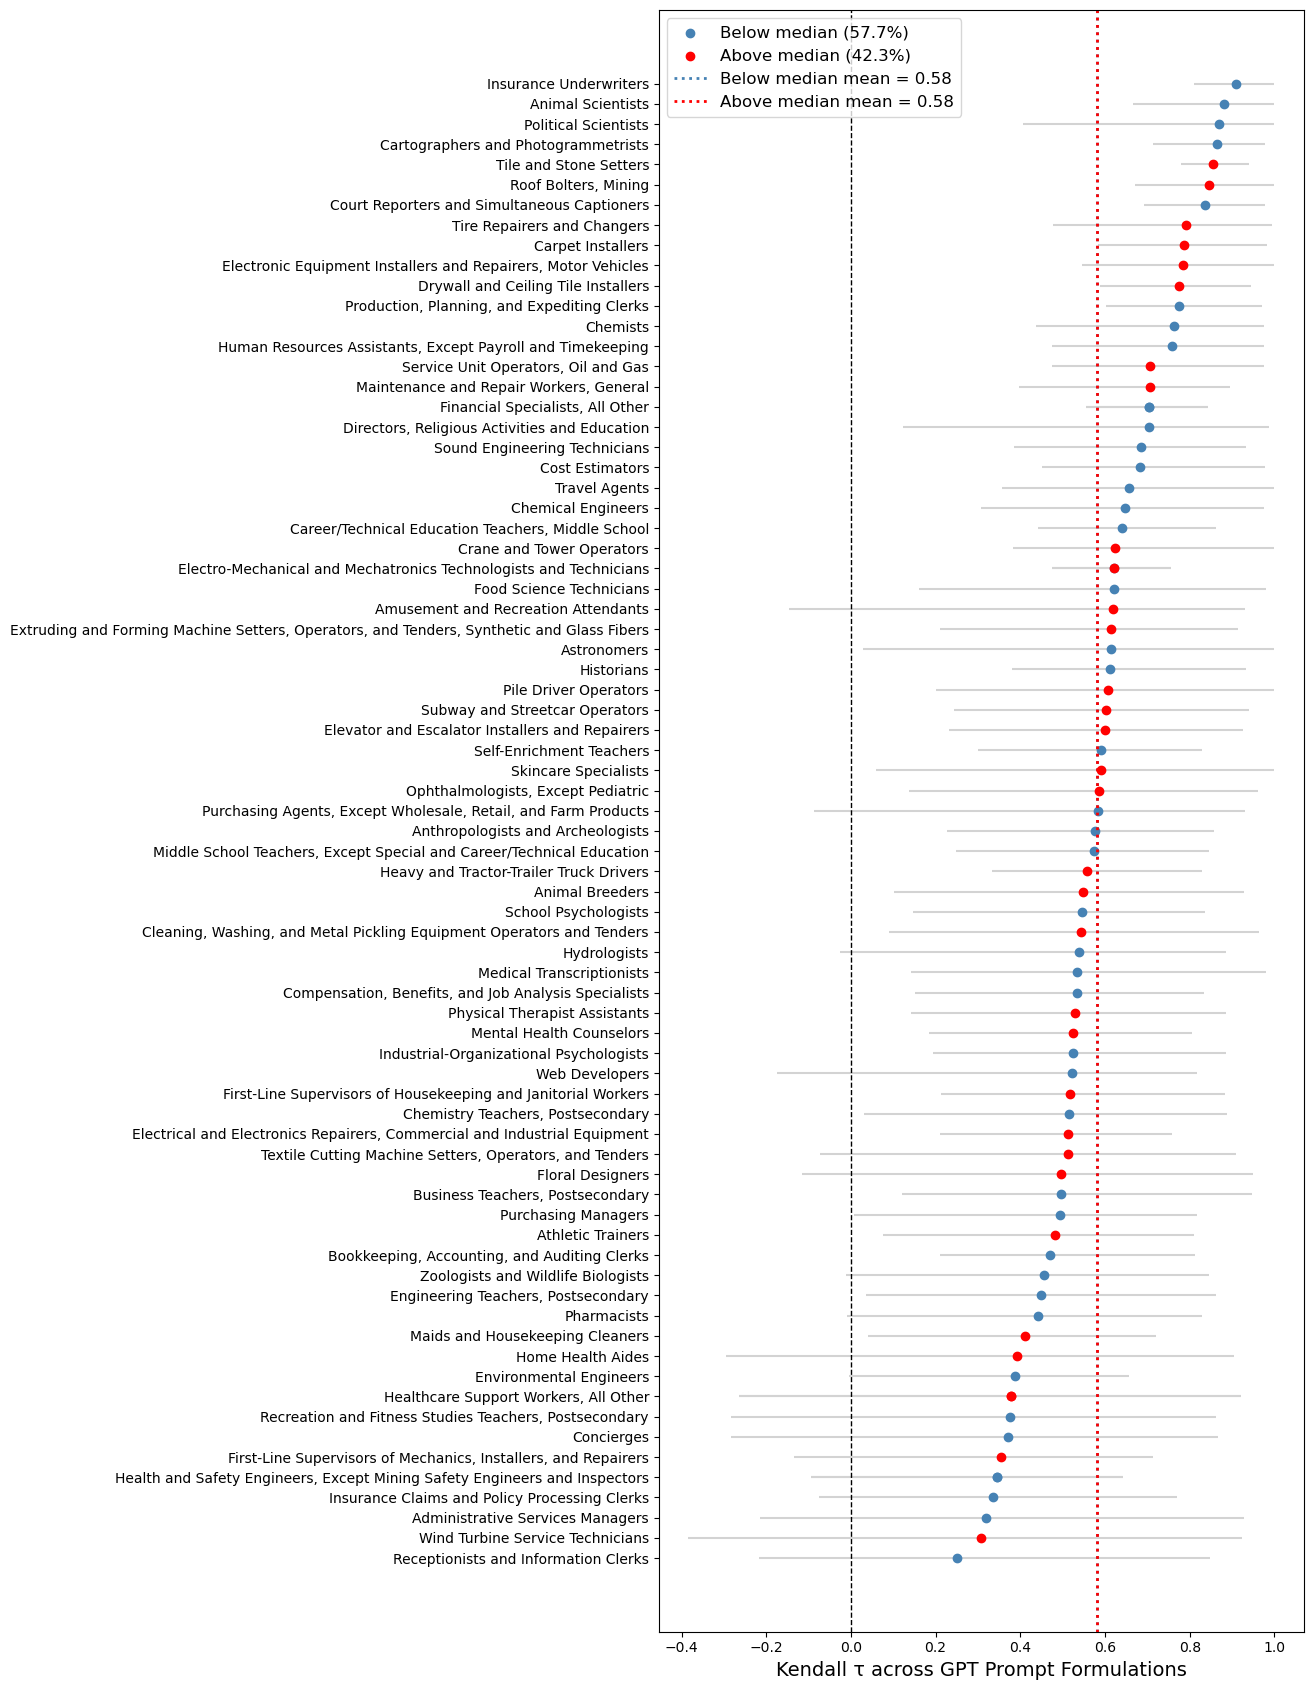

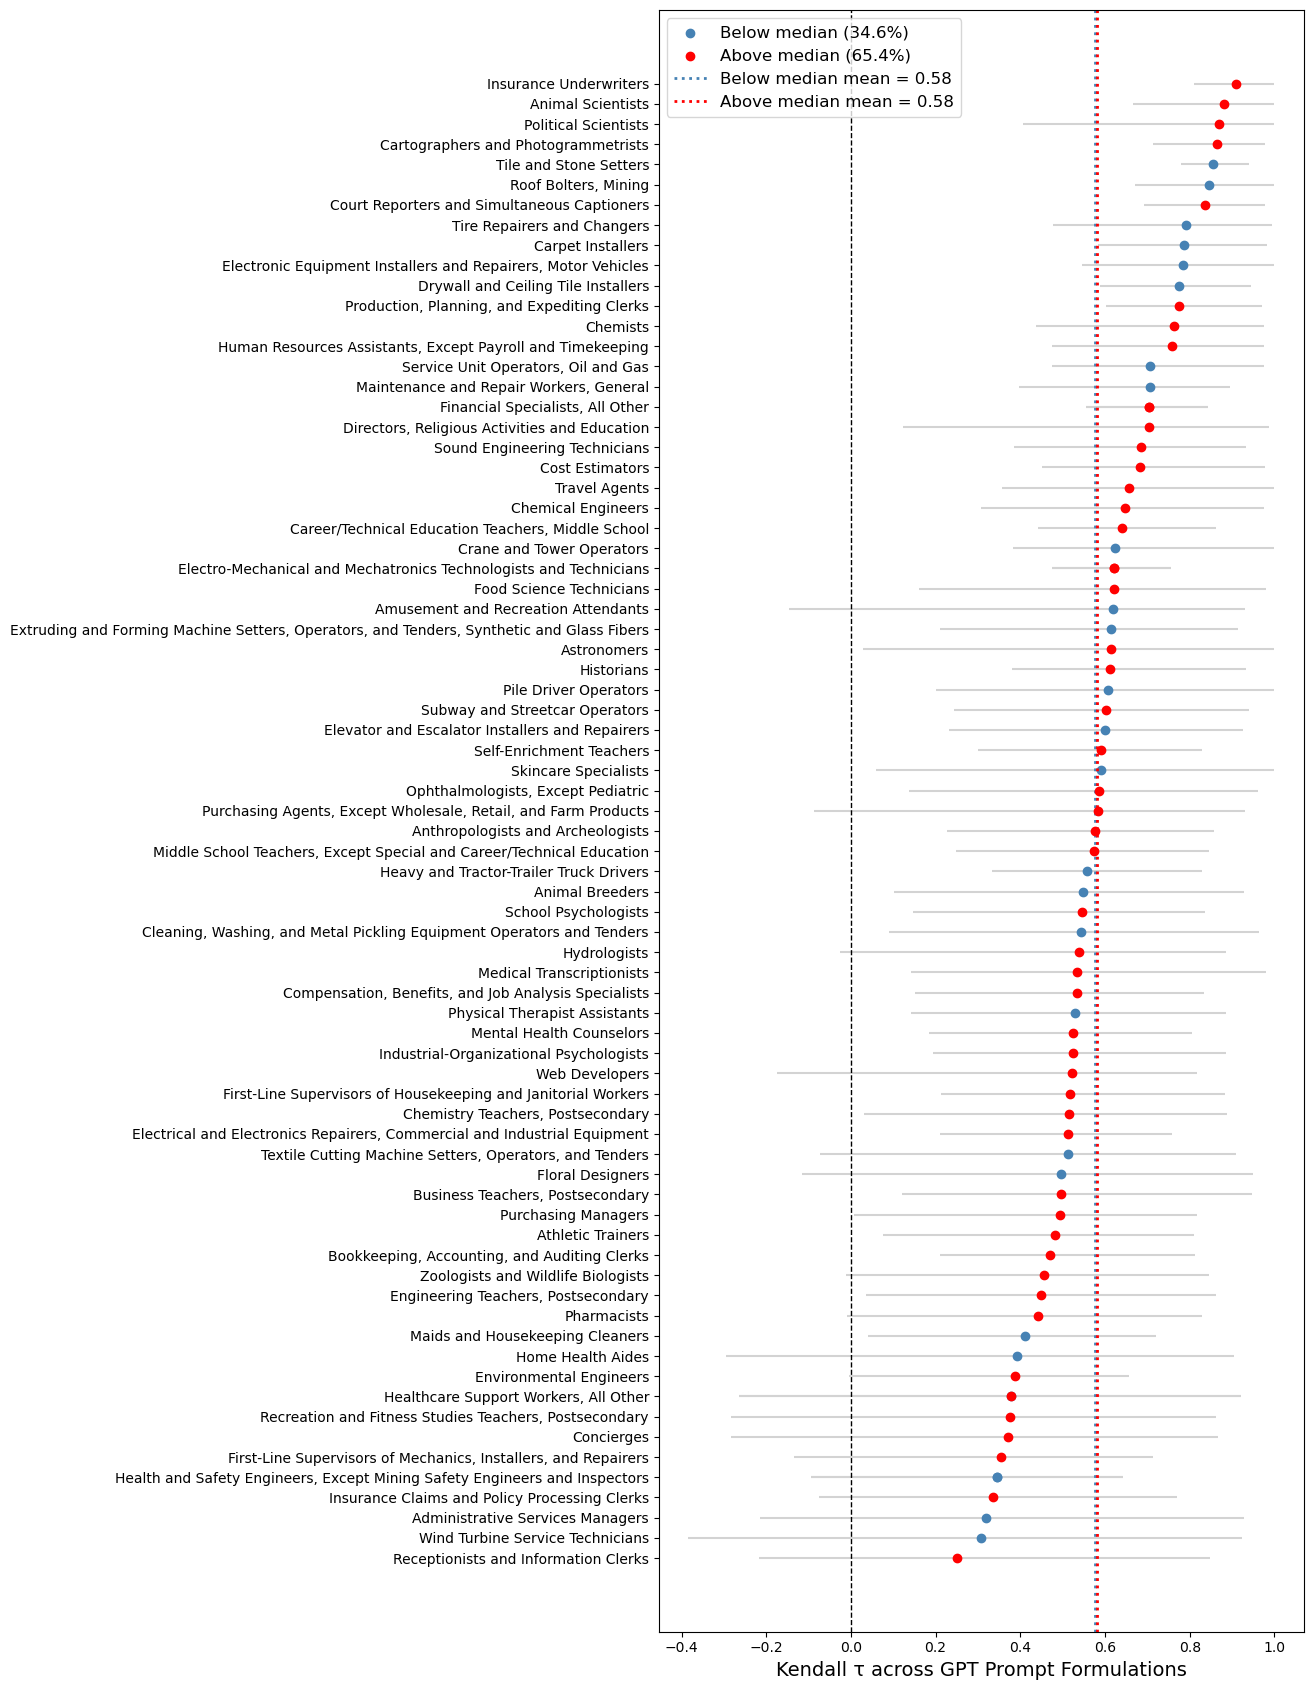

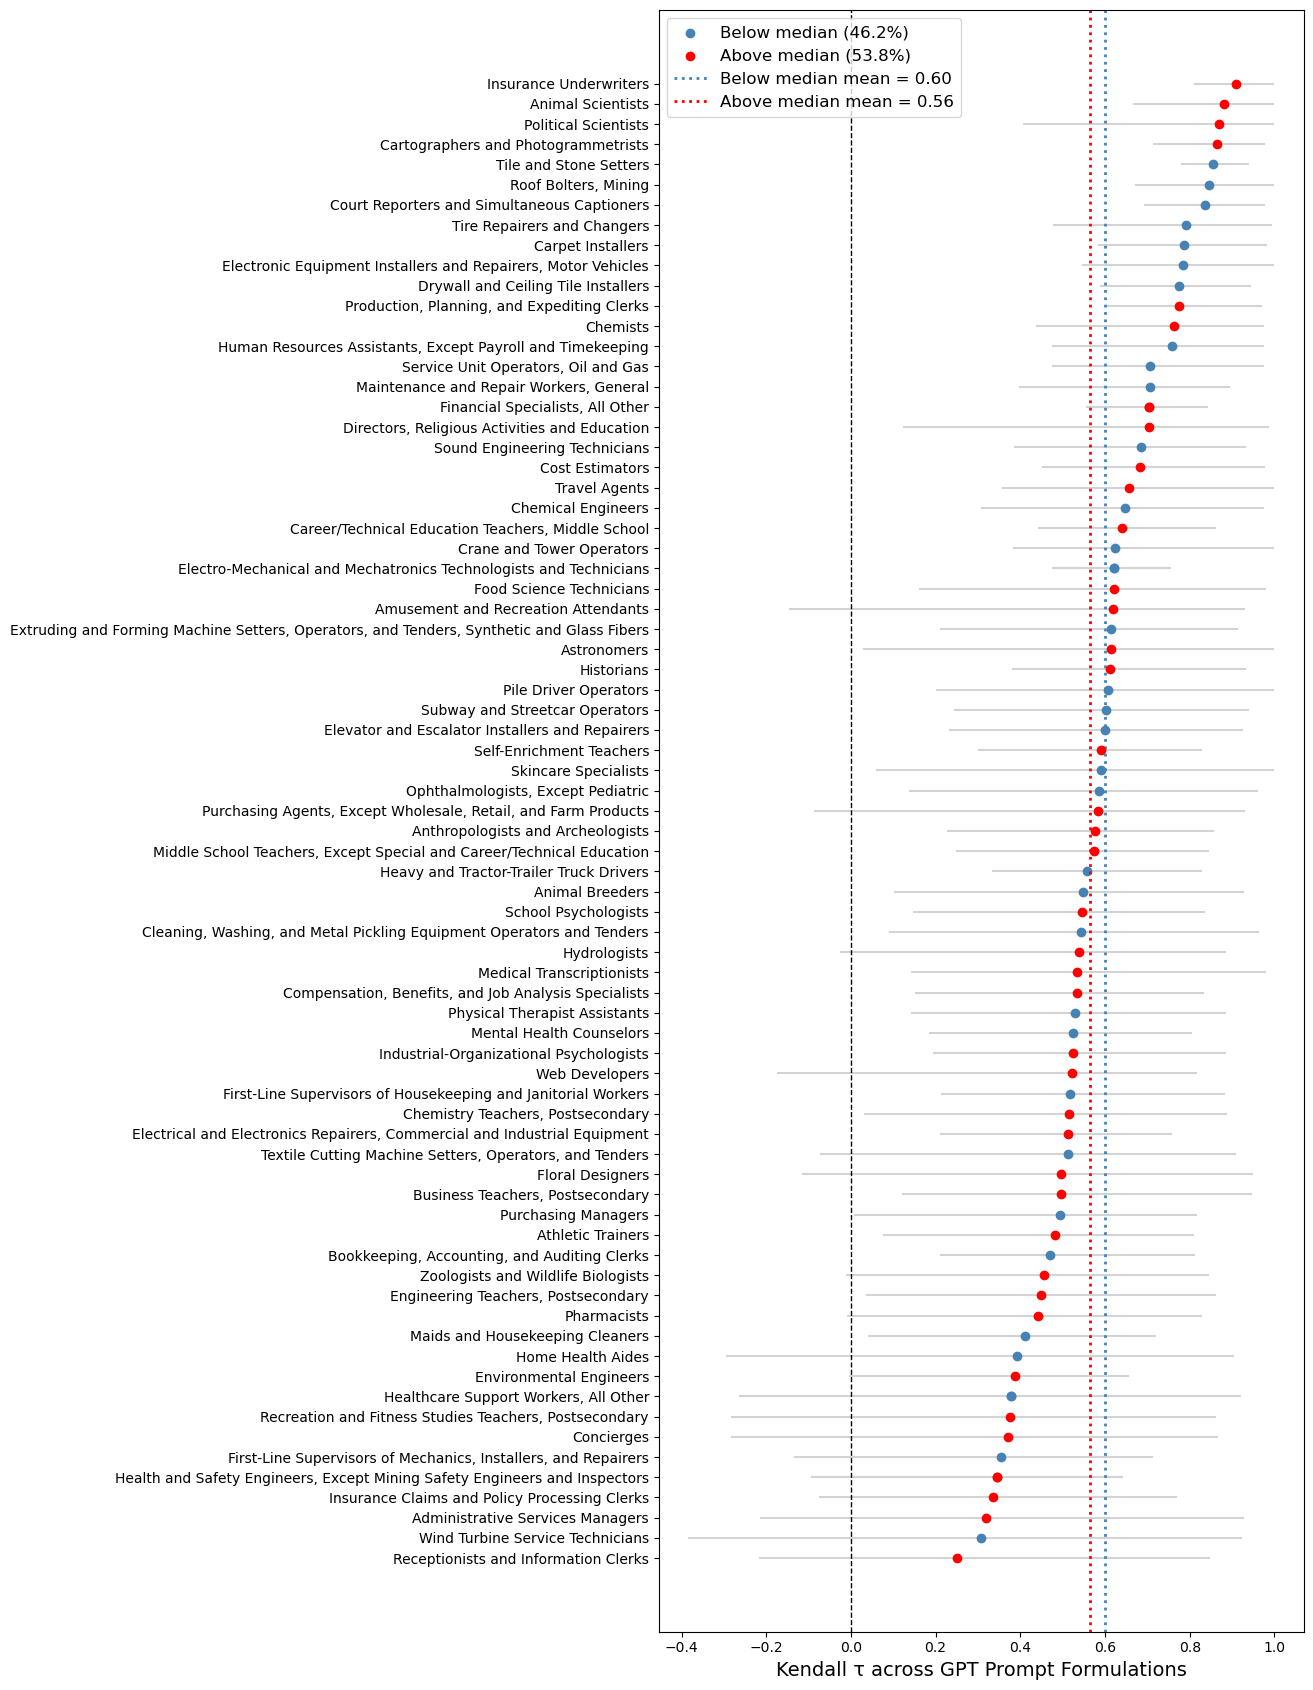

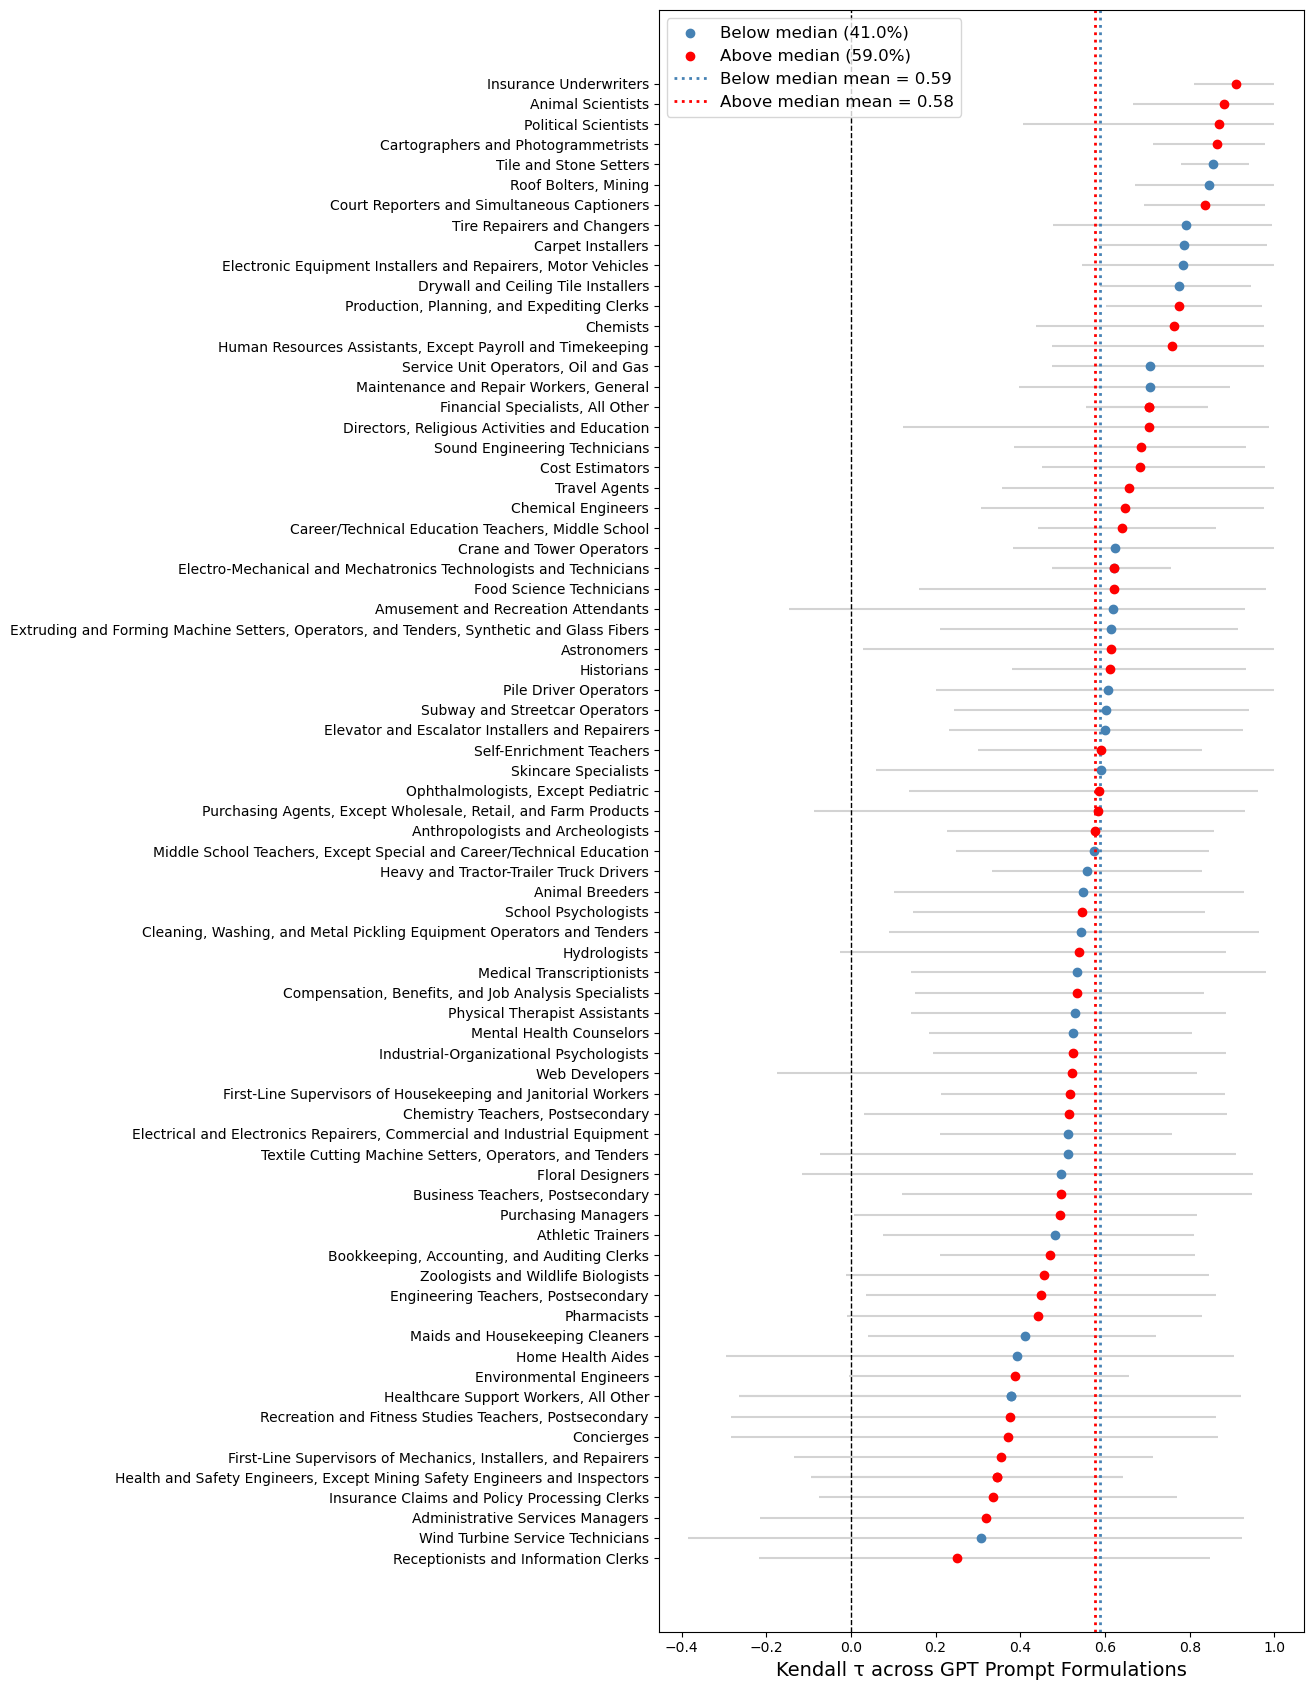

In [26]:
vars_and_titles = {
    "fragmentation_index_above_median": "Robustness to GPT Prompts by Empirical Fragmentation Index (Definition 2)",
    "ai_fraction_above_median": "Robustness to GPT Prompts by Share of AI-Executed Occupation Tasks",
    "human_E1_fraction_above_median": "Robustness to GPT Prompts by Share of AI-Exposed Occupation Tasks",
    "human_aiExposure_fraction_above_median": "Robustness to GPT Prompts by Share of AI-Exposed Occupation Tasks (E1 and E2)",
}

for var, title in vars_and_titles.items():
    plt.figure(figsize=(12, 17))

    # gray ranges
    plt.hlines(
        y=summary["occupation"],
        xmin=summary["min"],
        xmax=summary["max"],
        color="lightgray",
        zorder=1
    )

    # masks
    mask_red = summary[var] == 1
    mask_blue = ~mask_red

    # shares
    n_total = len(summary)
    share_red = mask_red.sum() / n_total
    share_blue = mask_blue.sum() / n_total

    label_blue = f"Below median ({share_blue:.1%})"
    label_red = f"Above median ({share_red:.1%})"

    # scatter
    plt.scatter(
        summary.loc[mask_blue, "mean"],
        summary.loc[mask_blue, "occupation"],
        color="steelblue",
        label=label_blue,
        zorder=2
    )

    plt.scatter(
        summary.loc[mask_red, "mean"],
        summary.loc[mask_red, "occupation"],
        color="red",
        label=label_red,
        zorder=3
    )

    # group means
    mean_blue = summary.loc[mask_blue, "mean"].mean()
    mean_red = summary.loc[mask_red, "mean"].mean()

    plt.axvline(
        mean_blue,
        color="steelblue",
        linestyle=":",
        linewidth=2,
        label=f"Below median mean = {mean_blue:.2f}"
    )
    plt.axvline(
        mean_red,
        color="red",
        linestyle=":",
        linewidth=2,
        label=f"Above median mean = {mean_red:.2f}"
    )

    # zero line
    plt.axvline(0, color="black", linestyle="--", linewidth=1)

    plt.xlabel("Kendall τ across GPT Prompt Formulations", fontsize=14)
    # plt.title(title)
    plt.legend(loc="upper left", fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(left=0.45)
    plt.savefig(
        f"{output_plot_path}/GPT_task_sequence_robustness_by_{var[:-13]}.png",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()

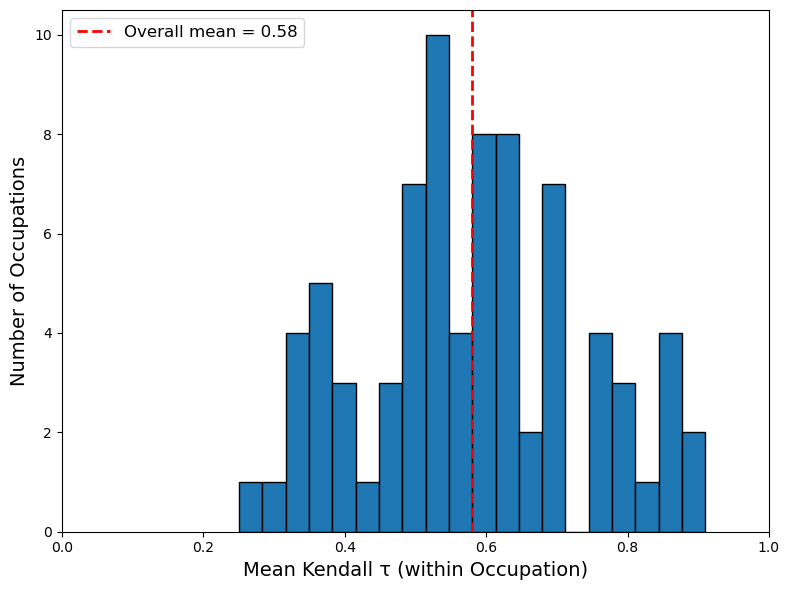

In [27]:
plt.figure(figsize=(8, 6))
plt.hist(summary["mean"], bins=20, edgecolor='black')
plt.axvline(summary["mean"].mean(), color="red", linestyle="--", linewidth=2, label=f"Overall mean = {summary['mean'].mean():.2f}")
plt.xlabel("Mean Kendall τ (within Occupation)", fontsize=14)
plt.ylabel("Number of Occupations", fontsize=14)
# plt.title("Distribution of Task Ordering Robustness to Different GPT Prompts")
plt.xlim(0, 1)
plt.legend(loc="upper left", fontsize=12)
plt.tight_layout()
plt.savefig(f"{output_plot_path}/GPT_task_sequence_robustness_distribution.png", dpi=300)
plt.show()